# Working with DataFrames.jl v1.1.1

# Part 1

## Bogumił Kamiński

In this part of the tutorial we will use the *airports2.csv* file that is available for download here: https://www.kaggle.com/flashgordon/usa-airport-dataset. Therefore before starting it please be sure to download it and and have it un-zipped in your working directory.

Our objective is to show selected features of v1.1.1 release of the DataFrames.jl package.

This tutorial is not meant to be a replacement of a documentation - it just shows some practical application examples. If you want to know all the details of the discussed functionalities please refer to docstrings of the functions we show.

As usual in Julia, for every project you should have *Project.toml* and *Manifest.toml* files that specify the dependencies. They are bundled with this file in a GitHub gist.

If you do not have much experience with project dependencies and want to understand more about managing them I recommend you to read https://bkamins.github.io/julialang/2020/05/18/project-workflow.html.

This tutorial was developed under Julia 1.6.0.

Before we start let us make sure that you have the right versions of packages installed.

The output of the command below should be:
```
  [6e4b80f9] BenchmarkTools v0.7.0
  [336ed68f] CSV v0.8.4
  [8be319e6] Chain v0.4.6
  [a93c6f00] DataFrames v1.1.1
  [7073ff75] IJulia v1.23.2
  [0f8b85d8] JSON3 v1.8.1
  [91a5bcdd] Plots v1.13.2
```

In [1]:
] status

      Status `D:\DataFrames-Showcase\Project.toml`
  [6e4b80f9] BenchmarkTools v0.7.0
  [336ed68f] CSV v0.8.4
  [8be319e6] Chain v0.4.6
  [a93c6f00] DataFrames v1.1.1
  [7073ff75] IJulia v1.23.2
  [0f8b85d8] JSON3 v1.8.1
  [91a5bcdd] Plots v1.13.2


We start with loading the required packages and reading in the CSV file to a `DataFrame`:

In [2]:
using BenchmarkTools
using CSV
using DataFrames
using Dates
using Chain
using Plots

In [3]:
df = CSV.read("Airports2.csv", DataFrame)

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers
,String,String,String,String,Int64
1,MHK,AMW,"Manhattan, KS","Ames, IA",21
2,EUG,RDM,"Eugene, OR","Bend, OR",41
3,EUG,RDM,"Eugene, OR","Bend, OR",88
4,EUG,RDM,"Eugene, OR","Bend, OR",11
5,MFR,RDM,"Medford, OR","Bend, OR",0
6,MFR,RDM,"Medford, OR","Bend, OR",11
7,MFR,RDM,"Medford, OR","Bend, OR",2
8,MFR,RDM,"Medford, OR","Bend, OR",7
9,MFR,RDM,"Medford, OR","Bend, OR",7


Before we move on let us change the display settings to allow for printing wider outupt and reduce the numbe of lines printed.

In [4]:
ENV["LINES"] = 20 # lines are counted in number of rows printed

20

In [5]:
ENV["COLUMNS"] = 1000 # columns are counted in characters

1000

After these changes Jupyter Notebook shoud show us all columns of the data frame we have just loaded. Let us check it.

In [6]:
df

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
,String,String,String,String,Int64,Int64,Int64,Int64,Date,Int64,Int64,String,String,String,String
1,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140998840332,-96.6707992553711,NA,NA
2,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.1245994567871,-123.21199798584,44.2541008,-121.1500015
3,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.1245994567871,-123.21199798584,44.2541008,-121.1500015
4,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.1245994567871,-123.21199798584,44.2541008,-121.1500015
5,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015
6,MFR,RDM,"Medford, OR","Bend, OR",11,18,1,156,1990-03-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015
7,MFR,RDM,"Medford, OR","Bend, OR",2,72,4,156,1990-01-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015
8,MFR,RDM,"Medford, OR","Bend, OR",7,18,1,156,1990-09-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015
9,MFR,RDM,"Medford, OR","Bend, OR",7,36,2,156,1990-11-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015


Our data frame contains the following columns:

1. `:Origin_airport`: Three letter airport code of the origin airport
2. `:Destination_airport`: Three letter airport code of the destination airport
3. `:Origin_city`: Origin city name
4. `:Destination_city`: Destination city name
5. `:Passengers`: Number of passengers transported from origin to destination
6. `:Seats`: Number of seats available on flights from origin to destination
7. `:Flights`: Number of flights between origin and destination (multiple records for one month, many with flights > 1)
8. `:Distance`: Distance (to nearest mile) flown between origin and destination
9. `:Fly_date`: The date (yyyymm) of flight
10. `:Origin_population`: Origin city's population as reported by US Census
11. `:Destination_population`: Destination city's population as reported by US Census

Let us first investigate its metadata

In [7]:
size(df)

(3606803, 15)

In [8]:
nrow(df)

3606803

In [9]:
ncol(df)

15

In [10]:
names(df)

15-element Vector{String}:
 "Origin_airport"
 "Destination_airport"
 "Origin_city"
 "Destination_city"
 "Passengers"
 "Seats"
 "Flights"
 "Distance"
 "Fly_date"
 "Origin_population"
 "Destination_population"
 "Org_airport_lat"
 "Org_airport_long"
 "Dest_airport_lat"
 "Dest_airport_long"

In [11]:
propertynames(df)

15-element Vector{Symbol}:
 :Origin_airport
 :Destination_airport
 :Origin_city
 :Destination_city
 :Passengers
 :Seats
 :Flights
 :Distance
 :Fly_date
 :Origin_population
 :Destination_population
 :Org_airport_lat
 :Org_airport_long
 :Dest_airport_lat
 :Dest_airport_long

An important thing to note is that the `names` function returns a vector of `String`s and the `propertynames` function returns a vector of `Symbol`s.

In DataFrames.jl both strings and `Symbol`s can be used for column indexing.

Let us now get some summary statistics of our data set using the `describe` function:

In [12]:
describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,Origin_airport,,1B1,,ZZV,0,String
2,Destination_airport,,1B1,,ZZV,0,String
3,Origin_city,,"Aberdeen, SD",,"Zanesville, OH",0,String
4,Destination_city,,"Aberdeen, SD",,"Zanesville, OH",0,String
5,Passengers,2688.91,0,1118.0,89597,0,Int64
6,Seats,4048.3,0,1998.0,147062,0,Int64
7,Flights,37.2289,0,25.0,1128,0,Int64
8,Distance,697.319,0,519.0,5095,0,Int64
9,Fly_date,,1990-01-01,,2009-12-01,0,Date


In particular note that CSV.jl correctly idenfitied `:Fly_date` column as being a `Date` type.

When we investigate the summary statistics we note that there are flights that potentially have `0` passengers, `0` seats, or `0` flights.

In parctice if you get such data it is good to investigate it, as it shows some potential data quality issues.

Let us investigate into it (with a first deep-dive into new features of DataFrames.jl available since 0.21 release).

In [13]:
@chain df begin
    select(:Passengers, :Seats, :Flights)
    mapcols(ByRow(>(0)), _)
    groupby(:, sort=true)
    combine(nrow)
end

,Passengers,Seats,Flights,nrow
,Bool,Bool,Bool,Int64
1,0,0,0,11239
2,0,0,1,322787
3,0,1,0,94
4,0,1,1,51772
5,1,0,0,7
6,1,0,1,3
7,1,1,0,56
8,1,1,1,3220845


Before interpreting the results let us dissect the code:
1. `@chain` is a macro from Pipe.jl package, that makes it easy to chain function calls and makes `_` a placeholder for a value returned by a function that was earlier in the chain (you can read about the details here: https://github.com/jkrumbiegel/Chain.jl)
2. `select` creates a new data frame that keeps only three columns that we are interested in
3. `mapcols` transforms each column of our data frame to have `Bool` element; it will have a value `true` if an entry is greater than `0` and `false` otherwise. In this way we are able to easily idenfity rows with `0` entries, as they are most interesting for us
4. `groupby` groups our data frame by all columns and tells DataFrames.jl that the gorups should be sorted
5. finally `combine` just counts the number of rows in each group

Now going to our results - some of entries can be explained, like `0` passenges, but some seats and some flights (I guess it means that just no one took some flight).

However cases like some passengers, but `0` seats and `0` flights are probably a mistake in data (we have 7 rows that have this combination of values).

Let us try to find these 7 rows in two ways:

In [14]:
filter(row -> row.Passengers > 0 && row.Seats == 0 && row.Flights == 0, df)

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
,String,String,String,String,Int64,Int64,Int64,Int64,Date,Int64,Int64,String,String,String,String
1,ABR,PIR,"Aberdeen, SD","Pierre, SD",11,0,0,117,1997-11-01,39903,18289,45.4491004943848,-98.4217987060547,44.38270187,-100.2860031
2,IAD,BKW,"Washington, DC","Beckley, WV",2,0,0,215,2002-12-01,10029142,78851,38.94449997,-77.45580292,37.7873001099,-81.1241989136
3,IAD,BKW,"Washington, DC","Beckley, WV",1,0,0,215,2003-02-01,10172752,78587,38.94449997,-77.45580292,37.7873001099,-81.1241989136
4,IAD,BKW,"Washington, DC","Beckley, WV",2,0,0,215,2003-03-01,10172752,78587,38.94449997,-77.45580292,37.7873001099,-81.1241989136
5,BOS,LAS,"Boston, MA","Las Vegas, NV",9,0,0,2381,1993-06-01,8260582,877917,42.36429977,-71.00520325,36.08010101,-115.1520004
6,BKW,IAD,"Beckley, WV","Washington, DC",7,0,0,215,2002-12-01,78851,10029142,37.7873001099,-81.1241989136,38.94449997,-77.45580292
7,CMI,BMI,"Champaign, IL","Bloomington, IL",6,0,0,46,1997-11-01,201107,141699,40.03919983,-88.27809906,40.47710037,-88.91590118


In [15]:
subset(df, :Passengers => ByRow(>(0)), :Seats => ByRow(==(0)), :Flights  => ByRow(==(0)))

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
,String,String,String,String,Int64,Int64,Int64,Int64,Date,Int64,Int64,String,String,String,String
1,ABR,PIR,"Aberdeen, SD","Pierre, SD",11,0,0,117,1997-11-01,39903,18289,45.4491004943848,-98.4217987060547,44.38270187,-100.2860031
2,IAD,BKW,"Washington, DC","Beckley, WV",2,0,0,215,2002-12-01,10029142,78851,38.94449997,-77.45580292,37.7873001099,-81.1241989136
3,IAD,BKW,"Washington, DC","Beckley, WV",1,0,0,215,2003-02-01,10172752,78587,38.94449997,-77.45580292,37.7873001099,-81.1241989136
4,IAD,BKW,"Washington, DC","Beckley, WV",2,0,0,215,2003-03-01,10172752,78587,38.94449997,-77.45580292,37.7873001099,-81.1241989136
5,BOS,LAS,"Boston, MA","Las Vegas, NV",9,0,0,2381,1993-06-01,8260582,877917,42.36429977,-71.00520325,36.08010101,-115.1520004
6,BKW,IAD,"Beckley, WV","Washington, DC",7,0,0,215,2002-12-01,78851,10029142,37.7873001099,-81.1241989136,38.94449997,-77.45580292
7,CMI,BMI,"Champaign, IL","Bloomington, IL",6,0,0,46,1997-11-01,201107,141699,40.03919983,-88.27809906,40.47710037,-88.91590118


Let us compare the timing of both options:

In [16]:
@time filter(row -> row.Passengers > 0 && row.Seats == 0 && row.Flights == 0, df);

  0.930423 seconds (18.43 M allocations: 295.490 MiB, 10.18% gc time, 11.19% compilation time)


In [17]:
@time subset(df, :Passengers => ByRow(>(0)), :Seats => ByRow(==(0)), :Flights  => ByRow(==(0)));

  0.013042 seconds (380 allocations: 10.774 MiB)


Now let us move to another analysis.

We want to get an information about the occupancy of each flight. It can be calculated as ratio of the number of passengers and number of seats time number of flights. The problem is that if there are `0` seats or flights we would be dividing by `0` and get a `NaN` result. We prefer to get a `missing` value in this case. Therefore first define a helper function:

In [18]:
function get_occupied(passengers, seats, flights)
    if seats == 0 || flights == 0
        return missing
    else
        return passengers / (seats * flights)
    end
end

get_occupied (generic function with 1 method)

and now we use it to add a new column to our data frame. Additionally we create three new columns:
1. `:ost`: state of the origin city
2. `:dst`: state of the destination city
3. `:year`: year of flight

In [19]:
df2 = transform(df,
                [:Passengers, :Seats, :Flights] => ByRow(get_occupied) => :occupied,
                [:Origin_city, :Destination_city] .=> ByRow(x -> last(x, 2)) .=> [:ost, :dst],
                :Fly_date => ByRow(year) => :year)

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long,occupied,ost,dst,year
,String,String,String,String,Int64,Int64,Int64,Int64,Date,Int64,Int64,String,String,String,String,Float64?,String,String,Int64
1,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.140998840332,-96.6707992553711,NA,NA,0.7,KS,IA,2008
2,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.1245994567871,-123.21199798584,44.2541008,-121.1500015,0.00470615,OR,OR,1990
3,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.1245994567871,-123.21199798584,44.2541008,-121.1500015,0.0135426,OR,OR,1990
4,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.1245994567871,-123.21199798584,44.2541008,-121.1500015,0.0381944,OR,OR,1990
5,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015,0.0,OR,OR,1990
6,MFR,RDM,"Medford, OR","Bend, OR",11,18,1,156,1990-03-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015,0.611111,OR,OR,1990
7,MFR,RDM,"Medford, OR","Bend, OR",2,72,4,156,1990-01-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015,0.00694444,OR,OR,1990
8,MFR,RDM,"Medford, OR","Bend, OR",7,18,1,156,1990-09-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015,0.388889,OR,OR,1990
9,MFR,RDM,"Medford, OR","Bend, OR",7,36,2,156,1990-11-01,147300,76034,42.3741989135742,-122.873001098633,44.2541008,-121.1500015,0.0972222,OR,OR,1990


Note that in the computation we used `ByRow` wrapper that instructs DataFrames.jl to apply the function for each row of the passed data.

Here is an alternative way to compute `:occupied` without using `ByRow`, but instead using standard broadcasting:

In [20]:
get_occupied2(passengers, seats, flights) =
    @. ifelse((seats == 0) | (flights == 0), missing, passengers / (seats * flights))

get_occupied2 (generic function with 1 method)

In [21]:
df2′ = select(df, [:Passengers, :Seats, :Flights] => get_occupied2 => :occupied)

,occupied
,Float64?
1,0.7
2,0.00470615
3,0.0135426
4,0.0381944
5,0.0
6,0.611111
7,0.00694444
8,0.388889
9,0.0972222


First we check if both methods produced the same result:

In [22]:
isequal(df2.occupied, df2′.occupied)

true

The second thing we can do is compare the performance of both options:

In [23]:
@benchmark select($df, [:Passengers, :Seats, :Flights] => ByRow(get_occupied) => :occupied)

BenchmarkTools.Trial: 
  memory estimate:  58.48 MiB
  allocs estimate:  131
  --------------
  minimum time:     16.133 ms (0.00% GC)
  median time:      17.250 ms (0.00% GC)
  mean time:        18.948 ms (8.25% GC)
  maximum time:     48.400 ms (64.15% GC)
  --------------
  samples:          264
  evals/sample:     1

In [24]:
@benchmark select($df, [:Passengers, :Seats, :Flights] => get_occupied2 => :occupied)

BenchmarkTools.Trial: 
  memory estimate:  58.48 MiB
  allocs estimate:  136
  --------------
  minimum time:     16.361 ms (0.00% GC)
  median time:      17.495 ms (0.00% GC)
  mean time:        19.452 ms (8.17% GC)
  maximum time:     46.979 ms (55.53% GC)
  --------------
  samples:          257
  evals/sample:     1

As you can see DataFrames.jl does a decent job in this case - the option with `ByRow` is a tad faster than the broadcasting approach.

A crucial value of piping with `@chain` is that it composes also with functions outside of DataFrames.jl package.

Here is a simple example in which we will plot the total number of passengers that flew by year:

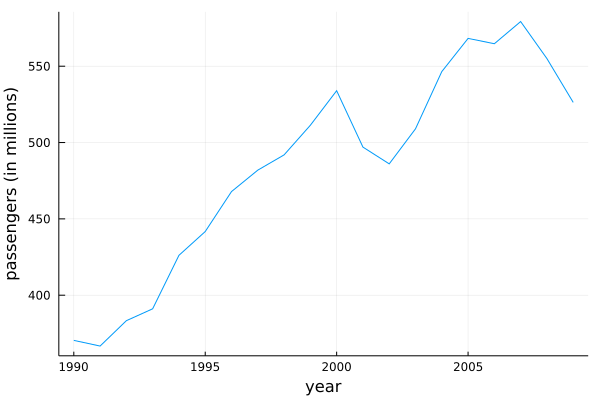

In [25]:
@chain df2 begin
    groupby(:year, sort=true)
    combine(:Passengers => sum)
    plot(_.year, _.Passengers_sum ./ 10^6, legend=nothing,
         xlab="year", ylab="passengers (in millions)")
end

I particular note that `_` notation from Chain.jl package allows you to write any valid code you could use on the passed value. In our case `plot` is passed a `DataFrame`, so we e.g. write `_.year` to get a `:year` column from it.

In the following example we will want to find pairs of origin-destination states that have the highest occupancy:

In [26]:
df3 = @chain df2 begin
    groupby([:ost, :dst])
    combine(:occupied => mean∘skipmissing => :occupied, :Passengers => sum)
    filter!(:occupied => isfinite, _)
    sort!(:occupied, rev=true)
end

,ost,dst,occupied,Passengers_sum
,String,String,Float64,Int64
1,NE,AK,1.0,180
2,MD,ID,1.0,150
3,ID,AR,1.0,124
4,ID,MS,1.0,181
5,ND,RI,1.0,50
6,WY,NY,0.991935,123
7,OR,RI,0.991935,123
8,WV,NE,0.984615,176
9,KS,ID,0.983871,122


In the above code note two things: we use `filter!` and `sort!` functions to process the data frame returned by `combine` in place (which reduces the number of allocations we make).

Additionally note that when we aggregate `:occupied` column in `combine` using `mean∘skipmissing` then for some origin-destination state combinations we get zero observations, which produce `NaN`, so we filter them out using `isfinite` predicate.

Just to make sure what happens when we apply `mean∘skipmissing` to a vector containing only missing values consider the following simple example:

In [27]:
@chain DataFrame(g=[1,1,2,2], v=[1,2,missing, missing]) begin
    groupby(:g)
    combine(:v => mean∘skipmissing)
end

,g,v_mean_skipmissing
,Int64,Float64
1,1,1.5
2,2,NaN


As a final example let us consider the following case. Assume that you want to query `df3` data frame by `:ost` and `:dst` columns very often.

The simplest way to do it is to use `subset` as we have already discussed:

In [28]:
subset(df3, :ost => ByRow(==("NE")), :dst => ByRow(==("AK")))

,ost,dst,occupied,Passengers_sum
,String,String,Float64,Int64
1,NE,AK,1.0,180


Now let us use a bit different technique. We `groupby` the `df3` data frame first:

In [29]:
gdf3 = groupby(df3, [:ost, :dst])

,ost,dst,occupied,Passengers_sum
,String,String,Float64,Int64
1,NE,AK,1.0,180
,ost,dst,occupied,Passengers_sum
,String,String,Float64,Int64
1,AK,VA,0.0,0


Now we can easiliy query it by group values (here we show such indexing by `Tuple` or `NamedTuple`):

In [30]:
gdf3[("NE", "AK")]

,ost,dst,occupied,Passengers_sum
,String,String,Float64,Int64
1,NE,AK,1.0,180


In [31]:
gdf3[(ost="NE", dst="AK")]

,ost,dst,occupied,Passengers_sum
,String,String,Float64,Int64
1,NE,AK,1.0,180


Note that you can use `keys` on `GroupedDataFrame`:

In [32]:
keys(gdf3)

2369-element DataFrames.GroupKeys{GroupedDataFrame{DataFrame}}:
 GroupKey: (ost = "NE", dst = "AK")
 GroupKey: (ost = "MD", dst = "ID")
 GroupKey: (ost = "ID", dst = "AR")
 GroupKey: (ost = "ID", dst = "MS")
 GroupKey: (ost = "ND", dst = "RI")
 GroupKey: (ost = "WY", dst = "NY")
 GroupKey: (ost = "OR", dst = "RI")
 GroupKey: (ost = "WV", dst = "NE")
 ⋮
 GroupKey: (ost = "RI", dst = "RI")
 GroupKey: (ost = "MN", dst = "DE")
 GroupKey: (ost = "AK", dst = "AR")
 GroupKey: (ost = "DE", dst = "MN")
 GroupKey: (ost = "AL", dst = "SD")
 GroupKey: (ost = "SC", dst = "SD")
 GroupKey: (ost = "AK", dst = "VA")

In this way we got only the origin-destination state combinations that are actually present in our `GroupedDataFrame`.

The ability to query a `GroupedDataFrame` by grouping columns fast makes it a very useful way to add an index to a data frame.